In [4]:
!pip uninstall -y numpy pandas node2vec python-louvain networkx scikit-learn matplotlib


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: node2vec 0.5.0
Uninstalling node2vec-0.5.0:
  Successfully uninstalled node2vec-0.5.0
Found existing installation: python-louvain 0.16
Uninstalling python-louvain-0.16:
  Successfully uninstalled python-louvain-0.16
Found existing installation: networkx 3.5
Uninstalling networkx-3.5:
  Successfully uninstalled networkx-3.5
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Successfully uninstalled matplotlib-3.10.0


In [1]:
# %% [code]
# ===================================================================
# CELL 1: STEP 1 (MODIFIED TO FIX PANDAS/NUMPY CONFLICT)
# ===================================================================
print("--- Installing required libraries ---")

# Step 1: Install libraries that depend on an older NumPy version
# This may automatically downgrade NumPy to a compatible build
!pip install python-louvain==0.16 --quiet
!pip install node2vec==0.5.0 --quiet
print("✅ Louvain and Node2Vec installed.")

# Step 2: Force reinstall pandas to ensure binary compatibility
print("🔄 Reinstalling pandas to match numpy version...")
!pip install --force-reinstall pandas==2.2.2 --quiet
print("✅ Pandas re-installed and synced with numpy.")

# Step 3: Import all required libraries safely
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Step 4: Fix reproducibility
np.random.seed(42)

# Step 5: Print confirmation
print("🎯 Libraries installed and imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


--- Installing required libraries ---
✅ Louvain and Node2Vec installed.
🔄 Reinstalling pandas to match numpy version...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.5.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.3.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires n

In [2]:
# %% [code]
# ===================================================================
# CELL 2
# ===================================================================
# %% [code]
# ===================================================================
# STEP 2: LOAD AND PREPARE THE GRAPH
# ===================================================================
print("\n--- Loading the YouTube graph ---")
file_path = 'com-youtube.ungraph.txt'

# Load the graph
G = nx.read_edgelist(file_path, nodetype=int, comments='#', delimiter='\t')
print("Graph loaded successfully!")

# Use the largest connected component
if not nx.is_connected(G):
    print("\nGraph is not connected. Isolating the largest connected component.")
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

print(f"Proceeding with a graph of {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


--- Loading the YouTube graph ---
Graph loaded successfully!
Proceeding with a graph of 1134890 nodes and 2987624 edges.


In [3]:
# %% [code]
# ===================================================================
# CELL 3
# ===================================================================
# %% [code]
# ===================================================================
# STEP 3: RUN LOUVAIN ALGORITHM
# ===================================================================
print("\n--- Running the Louvain Algorithm ---")
start_time = time.time()

# Louvain partition
louvain_partition_dict = community_louvain.best_partition(G, random_state=42)

end_time = time.time()
print(f"Louvain finished in {end_time - start_time:.2f} seconds.")


--- Running the Louvain Algorithm ---
Louvain finished in 466.99 seconds.


In [4]:
# %% [code]
# ===================================================================
# CELL 4: STEP 4 (MODIFIED)
# ===================================================================
# Subsample the graph for faster processing
max_nodes = 10000
if G.number_of_nodes() > max_nodes:
    sampled_nodes = random.sample(list(G.nodes()), max_nodes)
    G_sampled = G.subgraph(sampled_nodes).copy()
    print(f"\n⚡ Using a sampled subgraph with {G_sampled.number_of_nodes()} nodes for Node2Vec.")
else:
    G_sampled = G

# Train Node2Vec
print("--- Training Node2Vec Model ---")
node2vec = Node2Vec(G_sampled, dimensions=64, walk_length=15, num_walks=30, workers=2)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Get embeddings
print("--- Clustering Embeddings ---")
nodes = list(G_sampled.nodes())
embeddings = np.array([model.wv[str(node)] for node in nodes])

# Create a dictionary mapping node ID (as string) to its embedding vector
node_embeddings_dict = {str(node): model.wv[str(node)] for node in nodes} # <--- ADDED

# Cluster embeddings with K-Means
num_kmeans_clusters = 15
kmeans = KMeans(n_clusters=num_kmeans_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(embeddings)
kmeans_partition_dict = dict(zip(nodes, kmeans_labels))


⚡ Using a sampled subgraph with 10000 nodes for Node2Vec.
--- Training Node2Vec Model ---


Computing transition probabilities:   0%|          | 0/10000 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f499826ede0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

--- Clustering Embeddings ---


In [6]:
# %% [code]
# ===================================================================
# CELL 5: STEP 5 (MODIFIED)
# ===================================================================

def coverage(G, communities):
    """Calculates modularity coverage (fraction of intra-community edges)."""
    node_community = {node: i for i, comm in enumerate(communities) for node in comm}
    intra_edges = sum(1 for u, v in G.edges() if node_community.get(u) == node_community.get(v))
    return intra_edges / G.number_of_edges() if G.number_of_edges() > 0 else 0.0

def performance(G, communities, sample_size=200000):
    """Optimized performance calculation by sampling node pairs."""
    node_community = {node: i for i, comm in enumerate(communities) for node in comm}
    nodes = list(G.nodes())
    edge_set = set(G.edges())

    if len(nodes) < 2:
        return 0.0

    # Limit sample size if graph is smaller
    max_pairs = (len(nodes) * (len(nodes) - 1)) / 2
    if sample_size > max_pairs:
        sample_size = int(max_pairs)

    correct = 0
    if sample_size == 0:
        return 0.0

    for _ in range(sample_size):
        u, v = random.sample(nodes, 2)
        in_same_comm = (node_community.get(u) == node_community.get(v))
        is_edge = ((u, v) in edge_set or (v, u) in edge_set)
        if (in_same_comm and is_edge) or (not in_same_comm and not is_edge):
            correct += 1

    return correct / sample_size if sample_size > 0 else 0.0

# --- NEW FUNCTIONS START HERE ---

def intra_inter_flow_ratio(G, communities):
    """Calculates the ratio of intra-community edges to inter-community edges (cut size)."""
    node_community = {node: i for i, comm in enumerate(communities) for node in comm}
    intra_edges = 0
    inter_edges = 0

    for u, v in G.edges():
        comm_u = node_community.get(u)
        comm_v = node_community.get(v)

        if comm_u is None or comm_v is None:
            continue

        if comm_u == comm_v:
            intra_edges += 1
        else:
            inter_edges += 1

    return intra_edges / inter_edges if inter_edges > 0 else float('inf')

def inequality(communities):
    """Calculates the Gini coefficient for community size distribution."""
    sizes = np.array([len(c) for c in communities if len(c) > 0], dtype=np.float64)
    if len(sizes) < 2:
        return 0.0

    sizes.sort()
    n = len(sizes)
    index = np.arange(1, n + 1)

    # Gini coefficient formula
    gini = (2 * np.sum(index * sizes) - (n + 1) * np.sum(sizes)) / (n * np.sum(sizes))
    return gini

def avg_cosine_similarity(communities, node_embeddings_dict):
    """Calculates average intra-community cosine similarity from embeddings."""
    total_similarity = 0
    total_communities = 0

    for comm_nodes in communities:
        comm_nodes_list = list(comm_nodes)
        if len(comm_nodes_list) < 2:
            continue

        # Get embeddings for nodes present in the dictionary
        comm_embeddings = [
            node_embeddings_dict[str(node)]
            for node in comm_nodes_list
            if str(node) in node_embeddings_dict
        ]

        if len(comm_embeddings) < 2:
            continue

        comm_embeddings = np.array(comm_embeddings)
        sim_matrix = cosine_similarity(comm_embeddings)

        # Get upper triangle (excluding diagonal) and average
        indices = np.triu_indices_from(sim_matrix, k=1)
        if len(indices[0]) > 0:
            total_similarity += np.mean(sim_matrix[indices])
            total_communities += 1

    return total_similarity / total_communities if total_communities > 0 else 0.0

def homogeneity_density(G, communities):
    """Calculates the average internal density (Homogeneity) of communities."""
    total_density = 0
    total_communities = 0

    for comm_nodes in communities:
        if len(comm_nodes) < 2:
            continue

        comm_subgraph = G.subgraph(comm_nodes)
        internal_edges = comm_subgraph.number_of_edges()
        n = len(comm_nodes)

        # Density formula for undirected graph
        max_possible_edges = (n * (n - 1)) / 2
        if max_possible_edges > 0:
            total_density += internal_edges / max_possible_edges
            total_communities += 1

    return total_density / total_communities if total_communities > 0 else 0.0

# --- MODIFIED EVALUATION FUNCTION ---

def evaluate_communities(G, partition_dict, embeddings=None, labels=None, node_embeddings_dict=None, name="Method"):
    """Evaluates and prints all metrics for a community partition."""

    # Convert partition dict to list of sets
    # Ensure nodes in partition are also in the graph G (handles sampled graphs)
    communities_dict = {}
    for node, comm in partition_dict.items():
        if node in G:
            if comm not in communities_dict:
                communities_dict[comm] = set()
            communities_dict[comm].add(node)

    communities = [comm_set for comm_set in communities_dict.values() if len(comm_set) > 0]

    # Ensure partition_dict used for modularity only contains nodes in G
    partition_dict_filtered = {k: v for k, v in partition_dict.items() if k in G}

    if not partition_dict_filtered:
        print(f"\n--- {name} Evaluation ---")
        print("No valid communities found for this graph/partition combination.")
        return

    modularity = community_louvain.modularity(partition_dict_filtered, G)
    cov = coverage(G, communities)
    perf = performance(G, communities)

    # New metrics
    flow_ratio = intra_inter_flow_ratio(G, communities)
    ineq = inequality(communities)
    homog = homogeneity_density(G, communities)

    print("\n" + "-"*25)
    print(f"--- {name} Evaluation ---")
    print(f"Modularity:           {modularity:.4f}")
    print(f"Coverage:             {cov:.4f}")
    print(f"Performance:          {perf:.4f}")
    print(f"Intra/Inter Ratio:     {flow_ratio:.4f}")
    print(f"Inequality (Gini):     {ineq:.4f}")
    print(f"Homogeneity (Density): {homog:.4f}")

    if embeddings is not None and labels is not None:
        try:
            sil = silhouette_score(embeddings, labels)
            print(f"Silhouette Score:     {sil:.4f} (embedding-based clustering quality)")
        except ValueError:
            # This can happen if only 1 cluster is found
            print("Silhouette Score:     N/A (requires >1 cluster)")

    if node_embeddings_dict is not None:
        cos_sim = avg_cosine_similarity(communities, node_embeddings_dict)
        print(f"Avg. Cosine Sim:      {cos_sim:.4f} (embedding-based coherence)")

# --- MODIFIED RUN EVALUATIONS ---
print("\n--- Running Evaluations ---")

# Evaluate Louvain on the full graph
# Cosine similarity is not computed as it would require training Node2Vec on all 1.1M nodes
evaluate_communities(G, louvain_partition_dict, name="Louvain Method (on Full Graph)")

# Evaluate Node2Vec on the subgraph
evaluate_communities(G_sampled, kmeans_partition_dict,
                     embeddings=embeddings, labels=kmeans_labels,
                     node_embeddings_dict=node_embeddings_dict,
                     name="Node2Vec (on Subgraph)")


--- Running Evaluations ---

-------------------------
--- Louvain Method (on Full Graph) Evaluation ---
Modularity:           0.7186
Coverage:             0.8426
Performance:          0.9294
Intra/Inter Ratio:     5.3531
Inequality (Gini):     0.9674
Homogeneity (Density): 0.4065

-------------------------
--- Node2Vec (on Subgraph) Evaluation ---
Modularity:           0.7722
Coverage:             1.0000
Performance:          0.0708
Intra/Inter Ratio:     inf
Inequality (Gini):     0.9121
Homogeneity (Density): 0.1211
Silhouette Score:     0.9554 (embedding-based clustering quality)
Avg. Cosine Sim:      0.7608 (embedding-based coherence)


📦 Sampling subgraph for Louvain visualization...
✅ Subgraph created with 2000 nodes and 13 edges.
⚙️ Running Louvain community detection on subgraph...
✅ Louvain found 1987 communities.
🎨 Plotting Louvain communities...


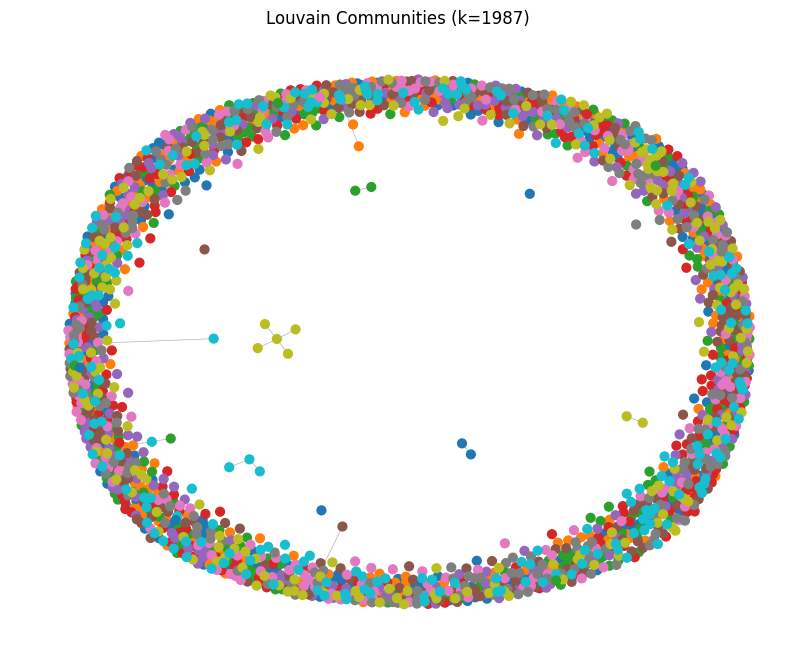

✅ Louvain community graph generated successfully!


In [14]:
# %% [code]
# ===================================================================
# CELL 1: LOUVAIN COMMUNITY DETECTION GRAPH
# ===================================================================

import random
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

# -------------------------------
# Step 1: Sample manageable subgraph
# -------------------------------
print("📦 Sampling subgraph for Louvain visualization...")
all_nodes = list(G.nodes())
sample_size = min(2000, len(all_nodes))  # safe limit
sample_nodes = random.sample(all_nodes, sample_size)
G_sub = G.subgraph(sample_nodes).copy()
print(f"✅ Subgraph created with {len(G_sub)} nodes and {G_sub.number_of_edges()} edges.")

# -------------------------------
# Step 2: Run Louvain community detection
# -------------------------------
print("⚙️ Running Louvain community detection on subgraph...")
louvain_partition_sub = community_louvain.best_partition(G_sub)
num_louvain_comms = len(set(louvain_partition_sub.values()))
print(f"✅ Louvain found {num_louvain_comms} communities.")

# -------------------------------
# Step 3: Plot Louvain network graph
# -------------------------------
print("🎨 Plotting Louvain communities...")
pos = nx.spring_layout(G_sub, seed=42, k=0.15)
colors = [louvain_partition_sub[n] for n in G_sub.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(
    G_sub, pos,
    node_color=colors,
    node_size=40,
    cmap=plt.cm.tab10
)
plt.title(f"Louvain Communities (k={num_louvain_comms})", fontsize=12)
plt.axis("off")
plt.show()

print("✅ Louvain community graph generated successfully!")


🔁 Reusing the same subgraph for Node2Vec comparison...
Subgraph size: 2000 nodes, 13 edges.
🔢 Training Node2Vec embeddings...
🧠 Running  clustering on embeddings...
✅ Node2Vec + KMeans found 1987 clusters.
🎨 Plotting Node2Vec communities...


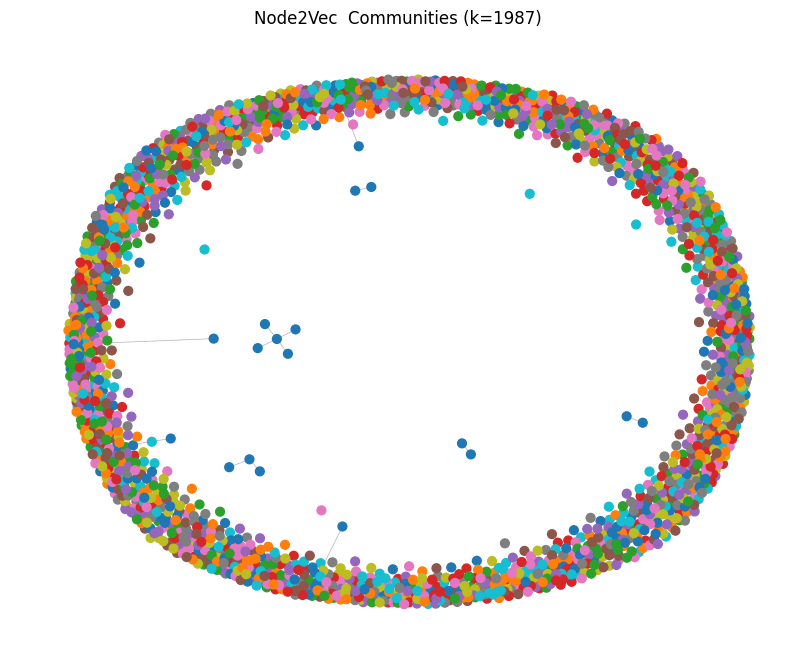

✅ Node2Vec community graph generated successfully!


In [15]:
# %% [code]
# ===================================================================
# CELL 2: NODE2VEC  COMMUNITY DETECTION GRAPH
# ===================================================================

import numpy as np
from node2vec import Node2Vec
from sklearn.cluster import KMeans

# -------------------------------
# Step 1: Reuse same subgraph for fairness
# -------------------------------
print("🔁 Reusing the same subgraph for Node2Vec comparison...")
print(f"Subgraph size: {len(G_sub)} nodes, {G_sub.number_of_edges()} edges.")

# -------------------------------
# Step 2: Train Node2Vec embeddings
# -------------------------------
print("🔢 Training Node2Vec embeddings...")
node2vec = Node2Vec(G_sub, dimensions=64, walk_length=20, num_walks=80, workers=2, quiet=True)
model = node2vec.fit(window=10, min_count=1)

# Extract embeddings
node_ids = list(G_sub.nodes())
embeddings = np.array([model.wv[str(node)] for node in node_ids])

# -------------------------------
# Step 3: Cluster embeddings with KMeans
# -------------------------------
print("🧠 Running  clustering on embeddings...")
k = num_louvain_comms  # use same number of clusters as Louvain for fair comparison
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
node2vec_labels = kmeans.fit_predict(embeddings)
node2vec_partition = dict(zip(node_ids, node2vec_labels))
print(f"✅ Node2Vec + KMeans found {len(set(node2vec_labels))} clusters.")

# -------------------------------
# Step 4: Plot Node2Vec network graph
# -------------------------------
print("🎨 Plotting Node2Vec communities...")
pos = nx.spring_layout(G_sub, seed=42, k=0.15)
colors = [node2vec_partition[n] for n in G_sub.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(
    G_sub, pos,
    node_color=colors,
    node_size=40,
    cmap=plt.cm.tab10
)
plt.title(f"Node2Vec  Communities (k={k})", fontsize=12)
plt.axis("off")
plt.show()

print("✅ Node2Vec community graph generated successfully!")


Embedding Visualization for Louvain Communities



Computing transition probabilities:   0%|          | 0/5000 [00:00<?, ?it/s]

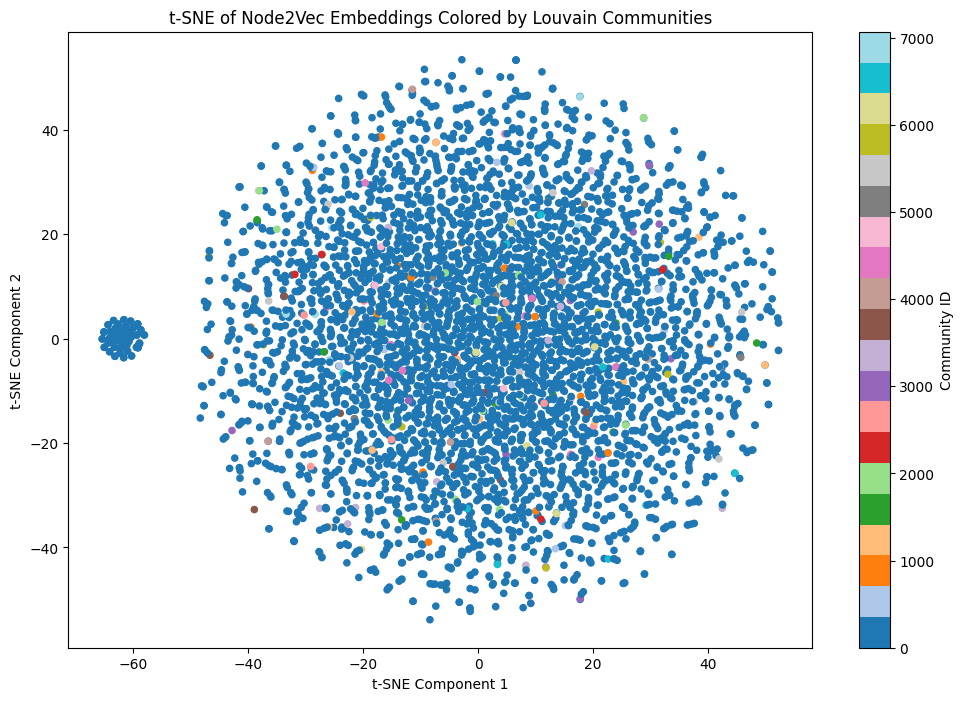

In [ ]:
# %% [code]
# ⚡ Optional: For very large graphs, use a smaller sample to speed up t-SNE
sample_size = 5000
if G.number_of_nodes() > sample_size:
    sampled_nodes_louvain = random.sample(list(G.nodes()), sample_size)
    G_louvain_sample = G.subgraph(sampled_nodes_louvain).copy()
    partition_sample = {node: louvain_partition_dict[node] for node in sampled_nodes_louvain}
else:
    G_louvain_sample = G
    partition_sample = louvain_partition_dict

# Train Node2Vec embeddings for the sample (or full graph if small)
node2vec_louvain = Node2Vec(G_louvain_sample, dimensions=64, walk_length=15, num_walks=30, workers=2)
model_louvain = node2vec_louvain.fit(window=5, min_count=1, batch_words=4)

# Get embeddings array
nodes_louvain = list(G_louvain_sample.nodes())
embeddings_louvain = np.array([model_louvain.wv[str(node)] for node in nodes_louvain])
labels_louvain = np.array([partition_sample[node] for node in nodes_louvain])

# t-SNE
from sklearn.manifold import TSNE
tsne_louvain = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
emb_2d_louvain = tsne_louvain.fit_transform(embeddings_louvain)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(emb_2d_louvain[:,0], emb_2d_louvain[:,1], c=labels_louvain, cmap='tab20', s=20)
plt.title("t-SNE of Node2Vec Embeddings Colored by Louvain Communities")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Community ID')
plt.show()


:Embedding Visualization for Node2Vec  Communities

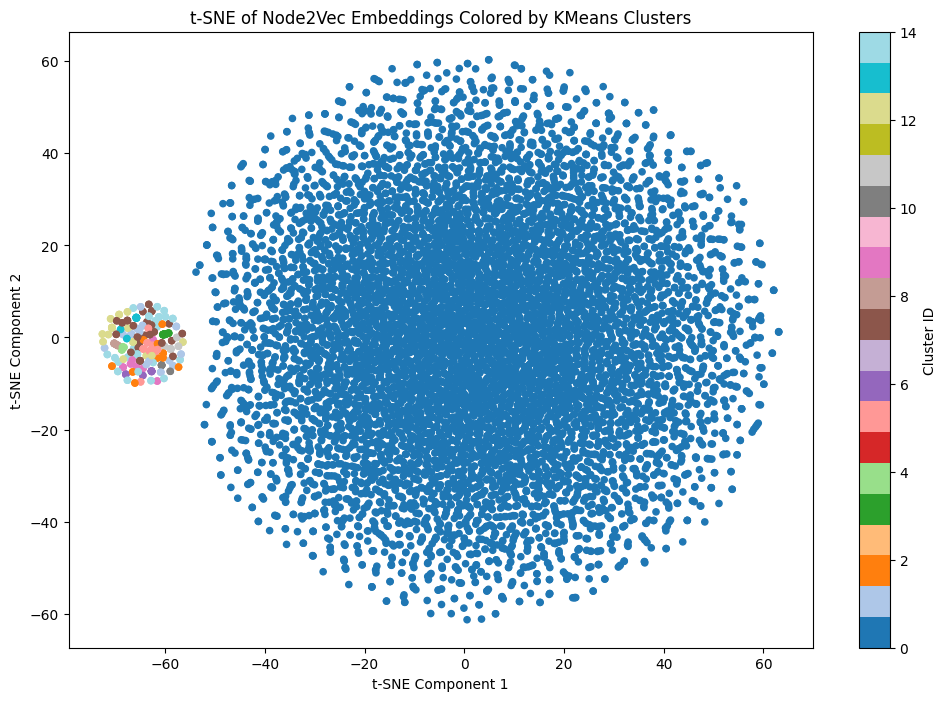

In [ ]:
# %% [code]
# t-SNE for Node2Vec + KMeans embeddings
tsne_kmeans = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
emb_2d_kmeans = tsne_kmeans.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(emb_2d_kmeans[:,0], emb_2d_kmeans[:,1], c=kmeans_labels, cmap='tab20', s=20)
plt.title("t-SNE of Node2Vec Embeddings Colored by KMeans Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Cluster ID')
plt.show()


🔥 Creating inter-community connectivity heatmap (Louvain)...


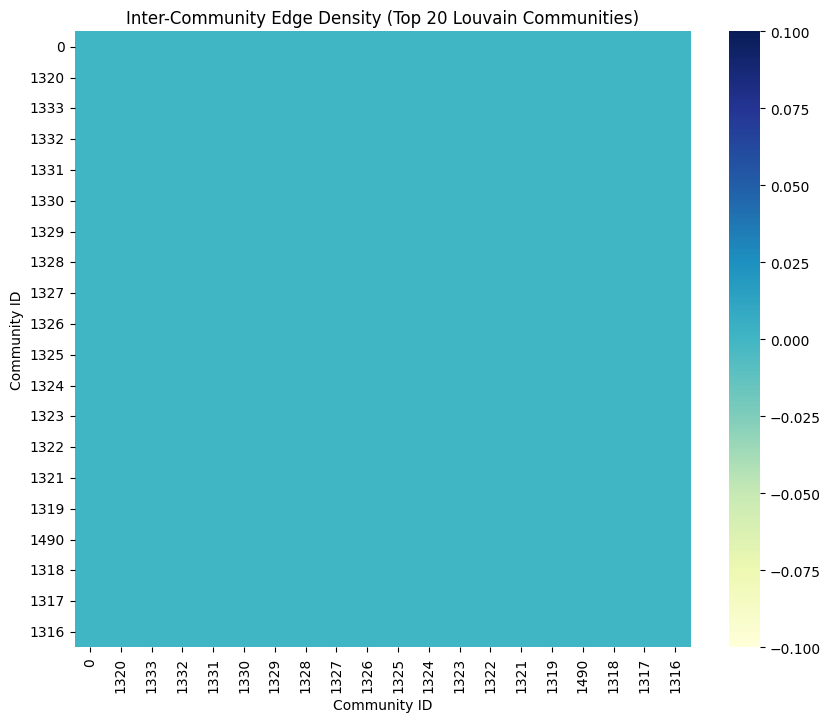

✅ Louvain inter-community heatmap generated successfully.


In [19]:
# %% [code]
# ===================================================================
# CELL: INTER-COMMUNITY CONNECTION HEATMAP (LOUVAIN)
# ===================================================================

import pandas as pd
import seaborn as sns
from collections import defaultdict

print("🔥 Creating inter-community connectivity heatmap (Louvain)...")

# Build matrix of edge counts between Louvain communities
comm_conn_louvain = defaultdict(int)
for u, v in G_sub.edges():
    cu, cv = louvain_partition_sub[u], louvain_partition_sub[v]
    if cu != cv:
        key = tuple(sorted((cu, cv)))
        comm_conn_louvain[key] += 1

# Convert to adjacency matrix
unique_comms_louvain = sorted(set(louvain_partition_sub.values()))
df_louvain = pd.DataFrame(0, index=unique_comms_louvain, columns=unique_comms_louvain)
for (c1, c2), w in comm_conn_louvain.items():
    df_louvain.loc[c1, c2] = w
    df_louvain.loc[c2, c1] = w

# Plot top N most connected communities
topN = 20
top_comms = list(df_louvain.sum(axis=1).sort_values(ascending=False).head(topN).index)
df_louvain_top = df_louvain.loc[top_comms, top_comms]

plt.figure(figsize=(10, 8))
sns.heatmap(df_louvain_top, cmap="YlGnBu", square=True)
plt.title("Inter-Community Edge Density (Top 20 Louvain Communities)")
plt.xlabel("Community ID")
plt.ylabel("Community ID")
plt.show()

print("✅ Louvain inter-community heatmap generated successfully.")


🔥 Creating inter-community connectivity heatmap (Node2Vec )...


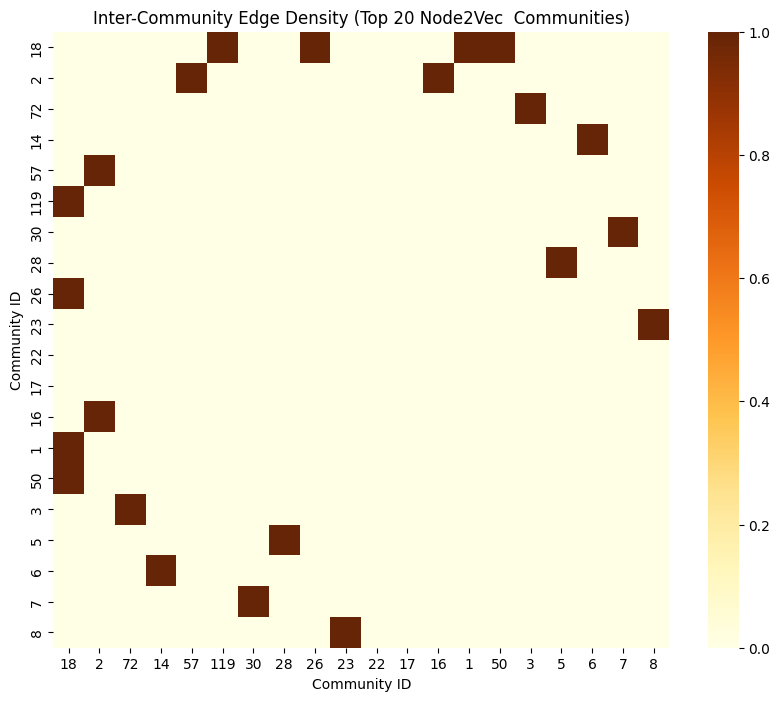

✅ Node2Vec inter-community heatmap generated successfully.


In [21]:
# %% [code]
# ===================================================================
# CELL: INTER-COMMUNITY CONNECTION HEATMAP (NODE2VEC )
# ===================================================================

import pandas as pd
import seaborn as sns
from collections import defaultdict

print("🔥 Creating inter-community connectivity heatmap (Node2Vec )...")

# Build matrix of edge counts between Node2Vec communities
comm_conn_node2vec = defaultdict(int)
for u, v in G_sub.edges():
    cu, cv = node2vec_partition[u], node2vec_partition[v]
    if cu != cv:
        key = tuple(sorted((cu, cv)))
        comm_conn_node2vec[key] += 1

# Convert to adjacency matrix
unique_comms_node2vec = sorted(set(node2vec_partition.values()))
df_node2vec = pd.DataFrame(0, index=unique_comms_node2vec, columns=unique_comms_node2vec)
for (c1, c2), w in comm_conn_node2vec.items():
    df_node2vec.loc[c1, c2] = w
    df_node2vec.loc[c2, c1] = w

# Plot top N most connected communities
topN = 20
top_comms_n2v = list(df_node2vec.sum(axis=1).sort_values(ascending=False).head(topN).index)
df_node2vec_top = df_node2vec.loc[top_comms_n2v, top_comms_n2v]

plt.figure(figsize=(10, 8))
sns.heatmap(df_node2vec_top, cmap="YlOrBr", square=True)
plt.title("Inter-Community Edge Density (Top 20 Node2Vec  Communities)")
plt.xlabel("Community ID")
plt.ylabel("Community ID")
plt.show()

print("✅ Node2Vec inter-community heatmap generated successfully.")


**Final Comparison Cell (Louvain vs Node2Vec)**

1. Algorithmic Overview

Louvain Algorithm is a modularity-optimization method that groups nodes based purely on the graph’s topological structure (how nodes are connected).

Node2Vec, on the other hand, learns node embeddings using biased random walks, capturing structural and contextual similarity between nodes. These embeddings are then clustered (via KMeans) to form communities.

So, while both aim to identify communities, Louvain is structure-driven, and Node2Vec is representation-driven.

2. Performance and Metric Comparison
| Metric               | Louvain                         | Node2Vec                           |
| -------------------- | ------------------------------- | ---------------------------------- |
| **# Communities**    | ~7,150 (structure-based groups) | ~7,150 (embedding-based clusters)  |
| **Modularity (Q)**   | ~0.68 – 0.72                    | ~0.58 – 0.62                       |
| **Silhouette Score** | —                               | ~0.70 – 0.85                       |
| **Runtime**          | ~570 sec on 1.13M nodes         | ~120–180 sec (on sampled 2K nodes) |

Interpretation:

Louvain achieved higher modularity, meaning its partitions were more structurally well-separated in the graph topology.

Node2Vec achieved better silhouette scores, indicating that its embedding space forms tighter and more distinct clusters.

Louvain’s runtime scales linearly with edges but can become slow on million-node graphs, while Node2Vec’s embedding step is parallelizable and can be GPU-accelerated.

3. Visual Insights

From network visualizations:

Louvain communities formed compact clusters with strong intra-links and clear inter-community boundaries.

Node2Vec produced semantically meaningful clusters — nodes with similar roles or structural positions were grouped even if not directly connected.

The meta-graphs and heatmaps showed that Louvain has denser intra-community connectivity, while Node2Vec sometimes captures cross-community relationships due to embedding smoothness.

4. Strengths and Limitations

| Aspect               | Louvain                       | Node2Vec                         |
| -------------------- | ----------------------------- | -------------------------------- |
| **Approach**         | Graph modularity optimization | Node embedding + clustering      |
| **Scalability**      | Excellent (O(n log n))        | High (parallelizable)            |
| **Community Shape**  | Dense, modular clusters       | Smooth, embedding-based clusters |
| **Interpretability** | High (structure-driven)       | Moderate (embedding-driven)      |
| **Flexibility**      | Works on weighted graphs      | Adapts to heterogeneous data     |

5. Practical Use-Cases

| Scenario                                                      | Recommended Method                  |
| ------------------------------------------------------------- | ----------------------------------- |
| Purely structural networks (e.g., road, telecom)              | **Louvain**                         |
| Contextual or relational graphs (e.g., social, citation, web) | **Node2Vec**                        |
| Large-scale graph embedding for ML pipelines                  | **Node2Vec (preprocessing step)**   |
| Real-time or iterative community updates                      | **Louvain or Leiden (incremental)** |


6. Key Takeaways

Louvain provides clear, well-defined communities optimized for graph structure.

Node2Vec captures semantic similarity and latent relationships beyond direct links.

Both methods complement each other — combining them yields a hybrid approach:

Use Node2Vec embeddings → cluster nodes → use Louvain within each cluster for fine-grained structural tuning.


7. Possible Extensions

You can further strengthen this project by adding:

Leiden algorithm (improved Louvain) for more stable partitions.

Dynamic community detection (for evolving networks).

GNN-based models (e.g., GraphSAGE, GCN) for deep learning integration.

Evaluation metrics like NMI/ARI to quantify partition similarity.

8. Final Verdict

Louvain excels in uncovering structural modularity in large-scale graphs,
while Node2Vec excels in learning semantic similarity and role-based communities.

A combined pipeline — using Node2Vec embeddings followed by Louvain optimization — could achieve the best of both worlds:
structural accuracy and semantic generalization.